# Load data

## library

In [124]:
import pandas as pd 
import numpy as np 

In [125]:
train = pd.read_csv('dataset/train.csv', index_col = 'id')
test = pd.read_csv('dataset/test.csv', index_col = 'id')
submission = pd.read_csv('dataset/sample_submission.csv', index_col = 'id')

# Feature Engineering 

## concat train/test

In [126]:
all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop('target', axis = 1)

In [127]:
all_data['title'] = all_data['title'].str.replace('Land Rover' ,'LandRover')

train['title'] = train['title'].str.replace('Land Rover' ,'LandRover')
train['maker'] = [s[:len(s.split()[0])] for s in train['title']]
train['rank'] = train['target'].rank(ascending = False)
train['rank'] = train['rank'].astype(int)
pop_maker = train[train['rank'] < 10]['maker'].unique() # 상위 20위의 차의 브랜드


In [128]:
maker_sell = train['maker'].value_counts().to_dict()
train['maker'] = train['title'].apply(lambda x : x.split()[0])
train['maker'] = train['maker'].str.replace('Mercedes-Benz/52', 'Mercedes-Benz')
maker_rank = train.groupby('maker')['target'].median().sort_values(ascending = False).to_frame()
maker_rank['rank'] = maker_rank['target'].rank(ascending = False)
maker_rank = maker_rank.to_dict()

In [129]:
all_data['title'] = all_data['title'].str.replace('Land Rover' ,'LandRover')

all_data['maker'] = [s[:len(s.split()[0])] for s in all_data['title']]
all_data['product'] = [s[len(s.split()[0])+1:] for s in all_data['title']]
all_data['maker'] = all_data['maker'].replace({'Mercedes-Benz/52': 'Mercedes-Benz'})


all_data.drop('title', axis = 1, inplace = True)

all_data['transmission'] = all_data['transmission'].map({'automatic' : 0, 'manual' : 1})
all_data['fuel'] = all_data['fuel'].map({'petrol' : 0, 'diesel' : 1})
all_data['trans_fuel'] = all_data['transmission'].astype(str) + all_data['fuel'].astype(str)
all_data.drop(['transmission', 'fuel'], axis = 1, inplace = True)

all_data['isimported'] = all_data['isimported'].map({'New ' : 2,
                                               'Foreign Used' : 1,
                                               'Locally used' : 0})

all_data['engine'] = [s.split('-')[0] for s in all_data['engine']]
all_data['engine'] = all_data['engine'].astype(int)

all_data['location'] = all_data['location'].replace({'Lagos ' : 'Lagos',
                                           'Lagos State' : 'Lagos',
                                           'Abuja ' : 'Abuja',
                                           'Abia State' : 'Abia',
                                           'Ogun State' : 'Ogun'})

all_data['year'] = all_data['year'].apply(lambda x : train['year'].mean() if x < 1900 else x)
all_data['year'] = [2020-s for s in all_data['year']]

all_data['paint'] = [s.lower() for s in all_data['paint']]
all_data['paint'] = [s.strip() for s in all_data['paint']]
all_data['paint'] = [s.replace('.', '') for s in all_data['paint']]
all_data['paint'] = [s.replace('off white l', 'off white') for s in all_data['paint']]
all_data['paint'] = [s.replace('skye', 'sky') for s in all_data['paint']]
all_data['paint'] = [s.replace('redl', 'red') for s in all_data['paint']]


# 비싼 가격의 차 특징

all_data['low_distance'] = [1 if s < 5000 else 0 for s in all_data['odometer']]
#all_data['pop_maker'] = [1 if s in pop_maker else 0 for s in all_data['maker']]
all_data['less3y'] = [1 if s < 3 else 0 for s in all_data['year']]
all_data['pop_color'] = [1 if ('white' in s or 'black' in s or s == 'grey') \
                         else 0 for s in all_data['paint']]
all_data['thisyear'] = [1 if s == 2020 else 0 for s in all_data['year']]

all_data['RR'] = [1 if s == 'Rolls-Royce' else 0 for s in all_data['maker']]
all_data['Bentley'] = [1 if s == 'Bentley' else 0 for s in all_data['maker']]
all_data['Ghost'] = [1 if s == 'Ghost' else 0 for s in all_data['product']]
all_data['LandRover'] = [1 if s == 'LandRover' else 0 for s in all_data['maker']]


all_data['distzero'] = [1 if s==0 else 0 for s in all_data['odometer']]
all_data['under500'] = [1 if (s>0 & s<500) else 0 for s in all_data['odometer']]

all_data['maker'] = all_data['maker'].str.replace('Mercedes-Benz/52', 'Mercedes-Benz')
all_data['maker_sell'] = all_data['maker'].map(maker_sell)
all_data['maker_sell'] = all_data['maker_sell'].fillna(0)
all_data['maker'] = all_data['maker'].map(maker_rank['rank'])
all_data['maker'] = all_data['maker'].fillna(len(maker_rank))

## One-Hot Encoding

In [130]:
cat_features = ['location', 'paint', 'product']
remaining_features =[col for col in all_data.columns if col not in cat_features]

In [131]:
from sklearn.preprocessing import MinMaxScaler

num_train = len(train)
scaler = MinMaxScaler()

scaler.fit(all_data.iloc[:num_train][remaining_features])

X = scaler.transform(all_data.iloc[:num_train][remaining_features])
X = pd.DataFrame(X, columns = remaining_features)

X_test = scaler.transform(all_data.iloc[num_train:][remaining_features])
X_test = pd.DataFrame(X_test, columns = remaining_features)

X = pd.concat([X, X_test])


In [132]:
X = X.reset_index().drop('index', axis = 1)
all_data_cat = all_data[cat_features].reset_index().drop('index', axis = 1)

In [133]:
all_data = pd.concat([X, all_data_cat], axis = 1)

In [134]:
all_data

,odometer,isimported,engine,year,maker,trans_fuel,low_distance,less3y,pop_color,thisyear,RR,Bentley,Ghost,LandRover,distzero,under500,maker_sell,location,paint,product
0,0.018512,0.5,0.333333,0.100,0.5750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,Lagos,red,RAV 4
1,0.000010,1.0,0.333333,0.025,0.5750,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,Lagos,black,Land Cruiser
2,0.084158,0.5,0.666667,0.200,0.0500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.038055,Lagos,red,Range Rover Evoque
3,0.092699,0.5,0.333333,0.325,0.3750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.255814,Lagos,gray,ES 350
4,0.095386,0.5,0.666667,0.250,0.5750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,Lagos,red,Venza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0.079179,0.5,0.666667,0.150,0.1500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.219873,Lagos,dark blue,GLK 350
1447,0.130882,0.5,0.666667,0.225,0.7875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.169133,Lagos,red,Crosstour
1448,0.102239,0.5,0.333333,0.175,0.1500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.219873,Lagos,black,ML 350
1449,0.082509,0.5,0.333333,0.425,0.3750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.255814,Lagos,mint green,GX 470


In [135]:
from sklearn.preprocessing import OneHotEncoder 

encoder = OneHotEncoder()
all_cat_encoded = encoder.fit_transform(all_data[cat_features])

all_cat_encoded

<1451x306 sparse matrix of type '<class 'numpy.float64'>'
	with 4353 stored elements in Compressed Sparse Row format>

In [136]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               all_cat_encoded],
                              format = 'csr')

In [137]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values
y = np.log(y)

# Training

## 평가지표 함수 생성

In [138]:
def eval_nmae(true, pred, toexp = True):
    
    if toexp : 
        true = np.expm1(true)
        pred = np.expm1(pred)
        
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

## RandomForest

In [139]:
from sklearn.ensemble import RandomForestRegressor

In [140]:
from sklearn.model_selection import KFold


# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    rf_model = RandomForestRegressor(n_estimators = 500)
    rf_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += rf_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += rf_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.2830921985517118

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.2907930093123164

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.28681624387505594

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.2530121491470335

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.2856548433722752



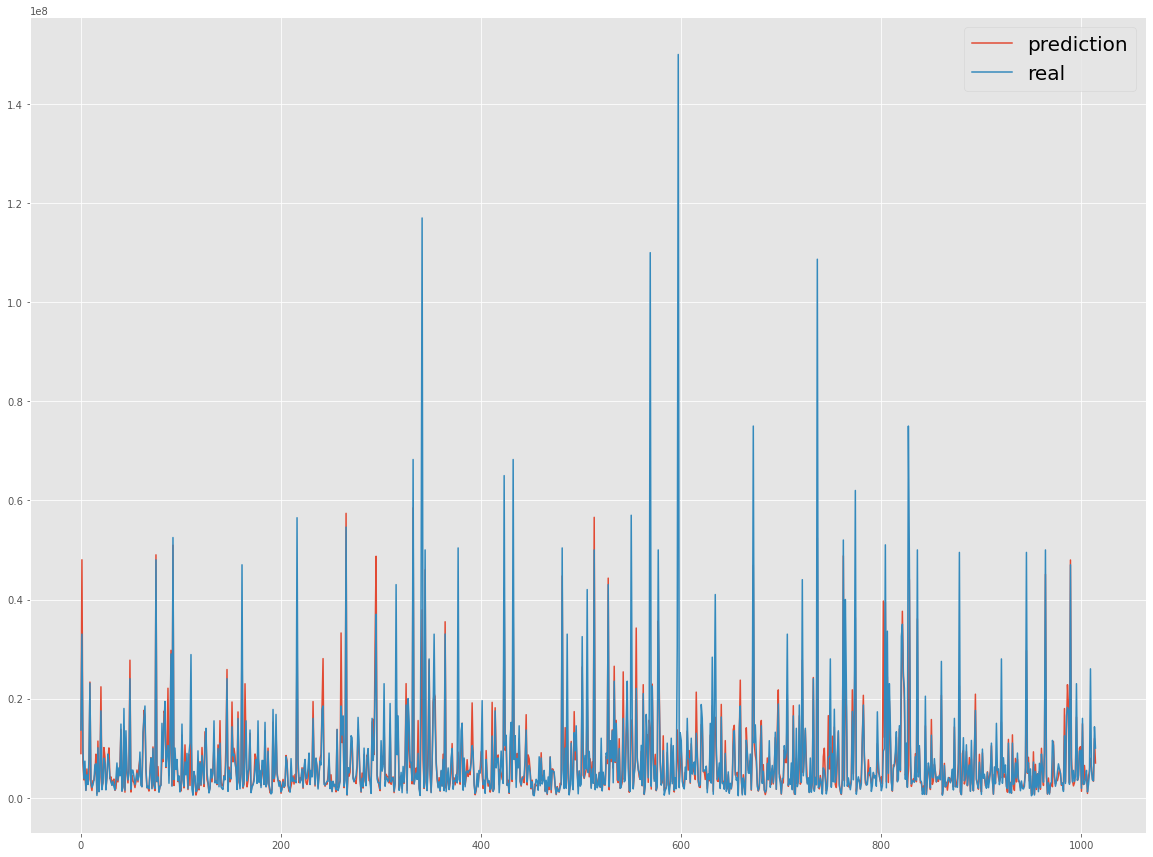

In [141]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

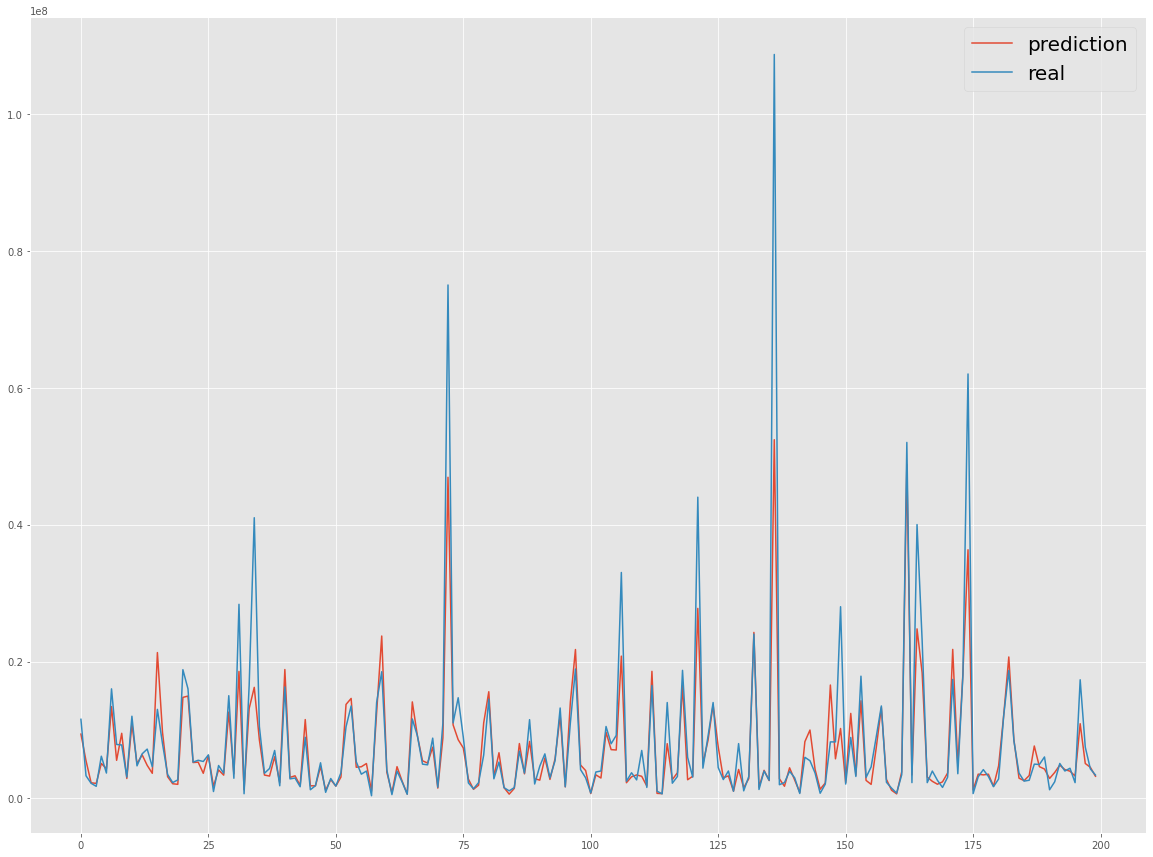

In [142]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [143]:
rf_valid_preds = oof_val_preds
rf_preds = oof_test_preds

## Ridge regression

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 

nmae_scorer = metrics.make_scorer(eval_nmae, greater_is_better = False)

In [145]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

ridge_model = Ridge()

ridge_params = {'max_iter' : [1000, 2000, 3000],
                'alpha' : [0.1, 0.5, 1, 2, 3, 5], }

gridcv_ridge_model = GridSearchCV(estimator = ridge_model, 
                                  param_grid = ridge_params, 
                                  scoring = nmae_scorer, 
                                  cv = 5)

gridcv_ridge_model.fit(X_train, y_train)

ridge_best_params = gridcv_ridge_model.best_params_

In [146]:
from sklearn.model_selection import KFold


# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    ridge_model = Ridge(**ridge_best_params)
    ridge_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += ridge_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += ridge_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.3046231276546463

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.35708895630572857

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.2769525826305211

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.2619169365367847

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.34177010820180714



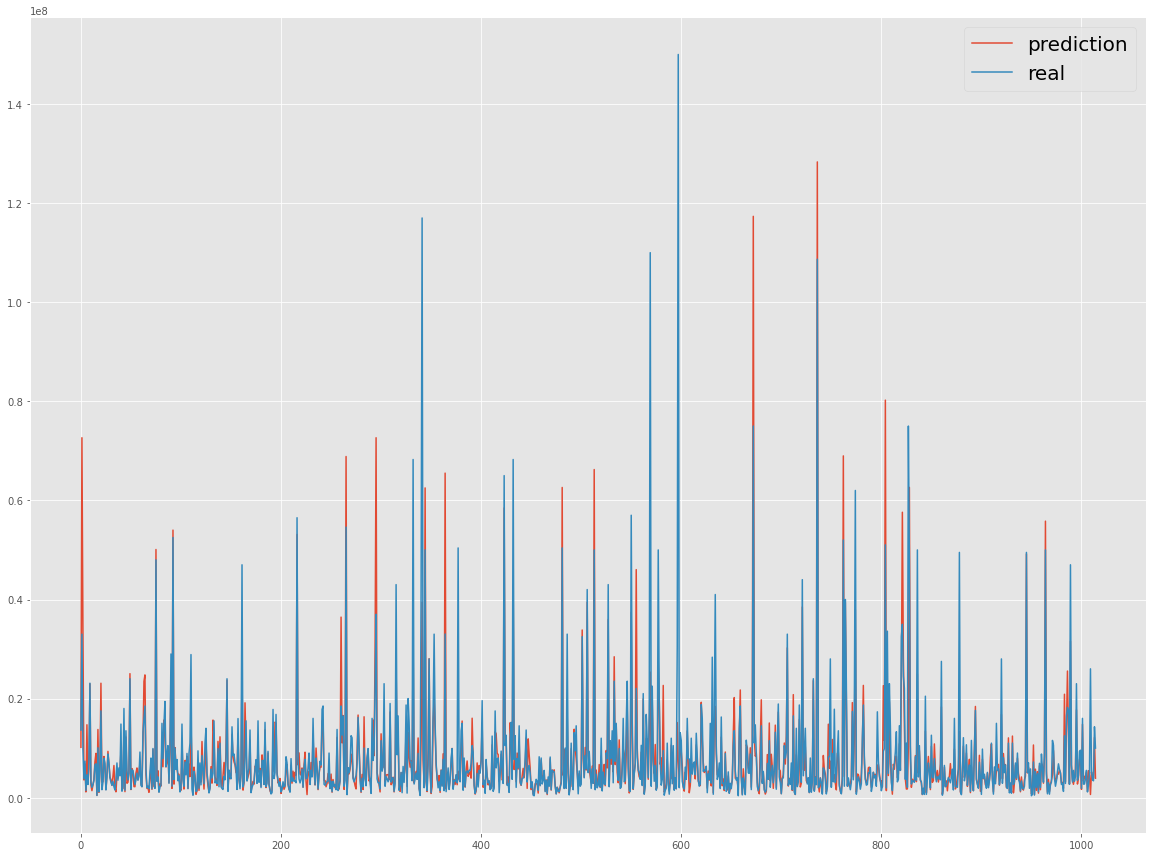

In [147]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

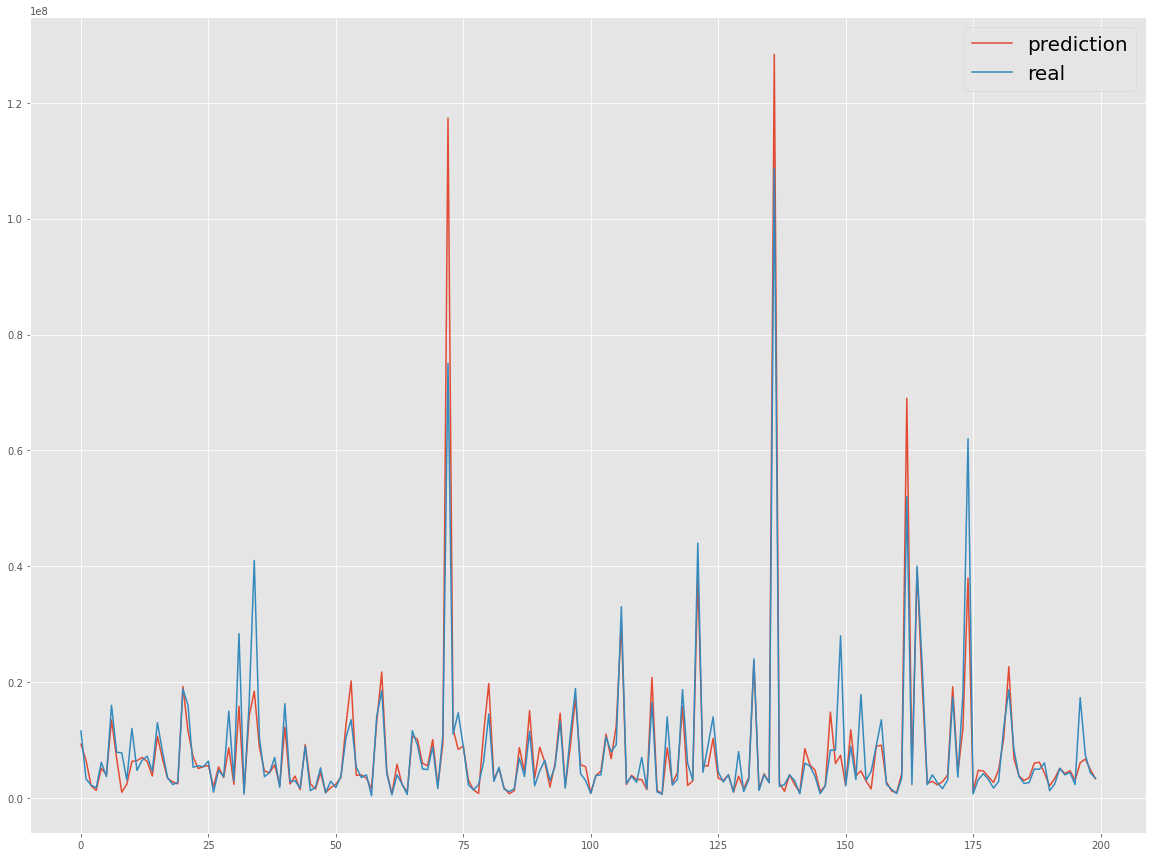

In [148]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [149]:
ridge_valid_preds = oof_val_preds
ridge_preds = oof_test_preds

## Light GBM

In [150]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    lgb_model = LGBMRegressor(n_estimators = 200)
    lgb_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += lgb_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.29775248848176367

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.3372512625603923

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.30133068267053426

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.29902570840814346

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.3081065392872794



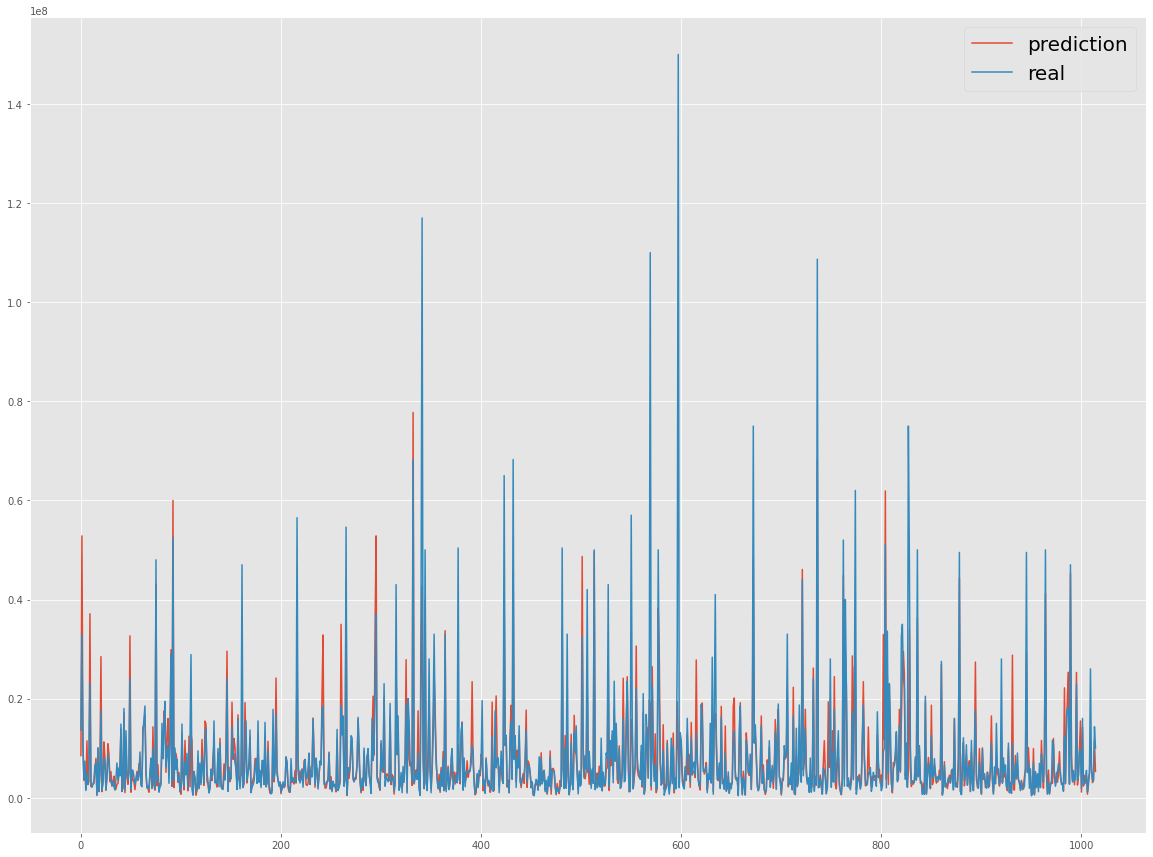

In [151]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

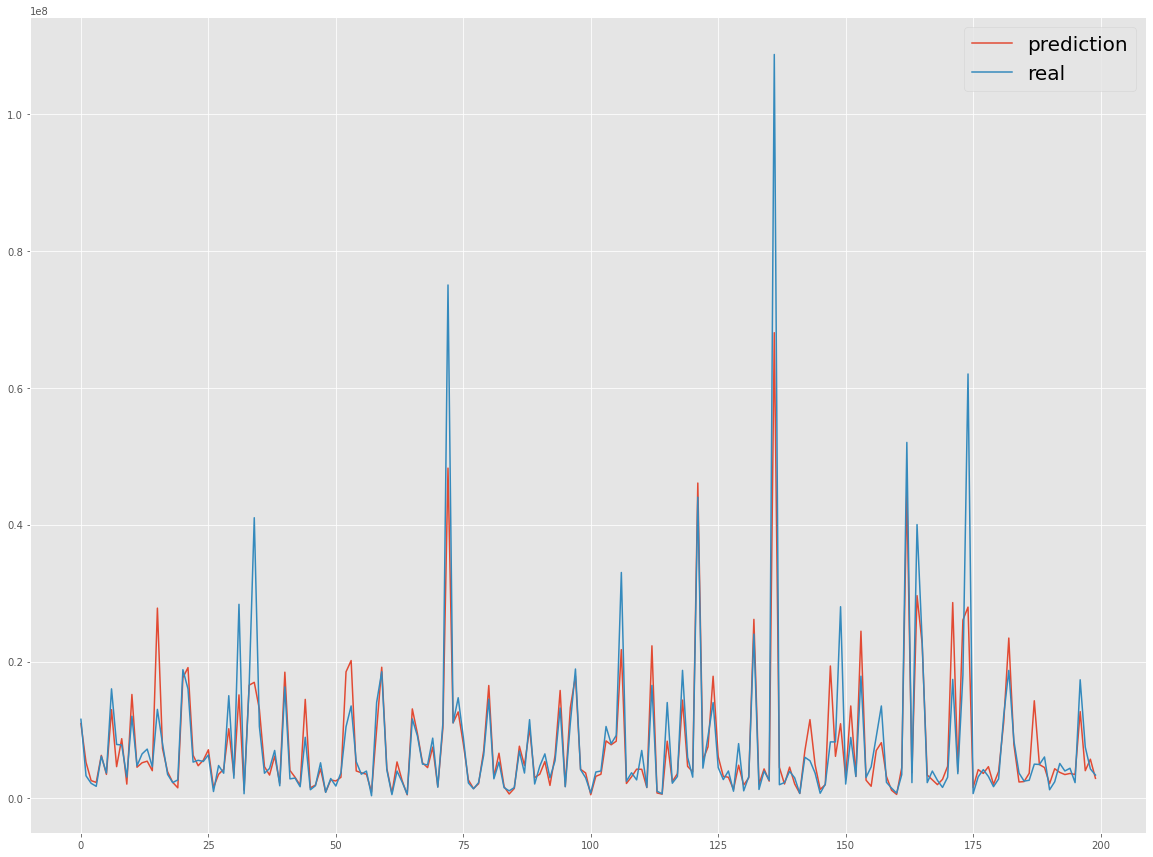

In [152]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [153]:
lgb_valid_preds = oof_val_preds
lgb_preds = oof_test_preds

## GradientBoostingRegressor

In [154]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += gb_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += gb_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
Fold 1 NMAE Coef. : 0.32042250792190413

######################################## Fold 2 / Fold 5 ########################################
Fold 2 NMAE Coef. : 0.3249102612242206

######################################## Fold 3 / Fold 5 ########################################
Fold 3 NMAE Coef. : 0.2765558013107711

######################################## Fold 4 / Fold 5 ########################################
Fold 4 NMAE Coef. : 0.2407846367259601

######################################## Fold 5 / Fold 5 ########################################
Fold 5 NMAE Coef. : 0.27937250985171097



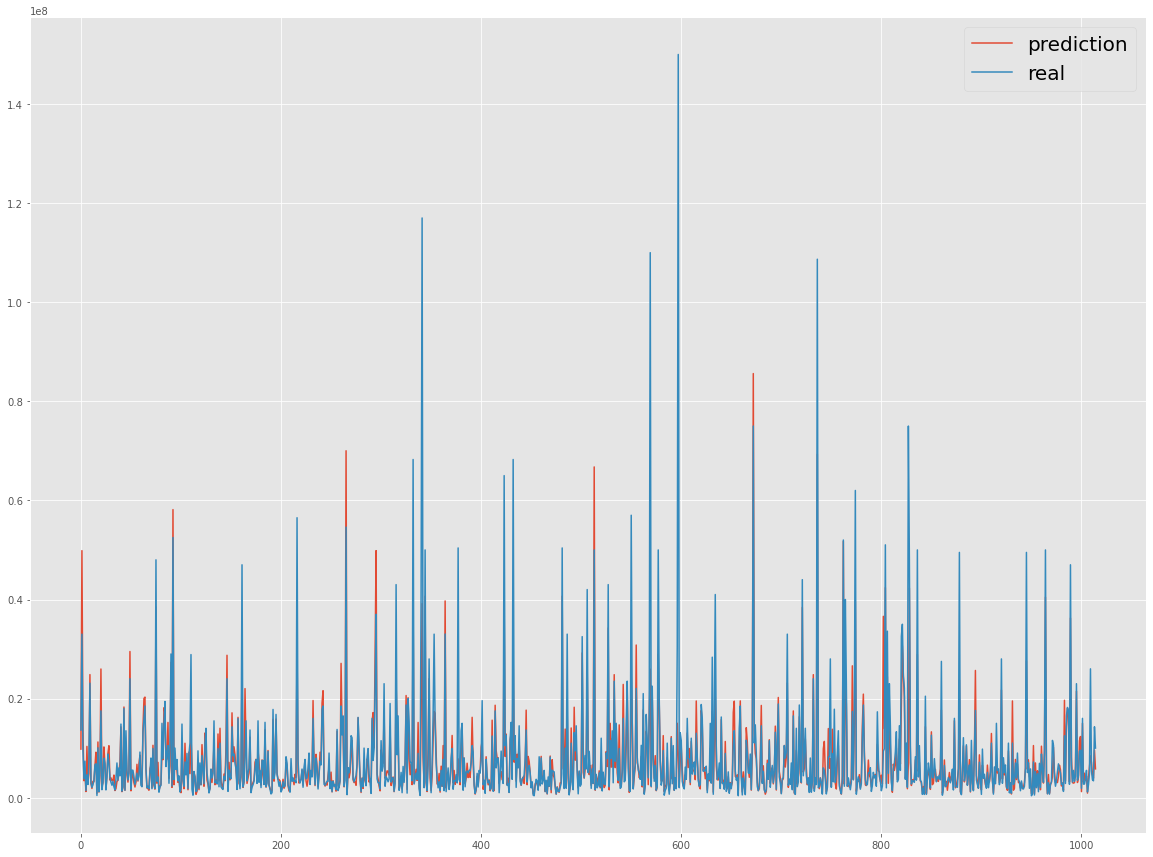

In [155]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds), label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

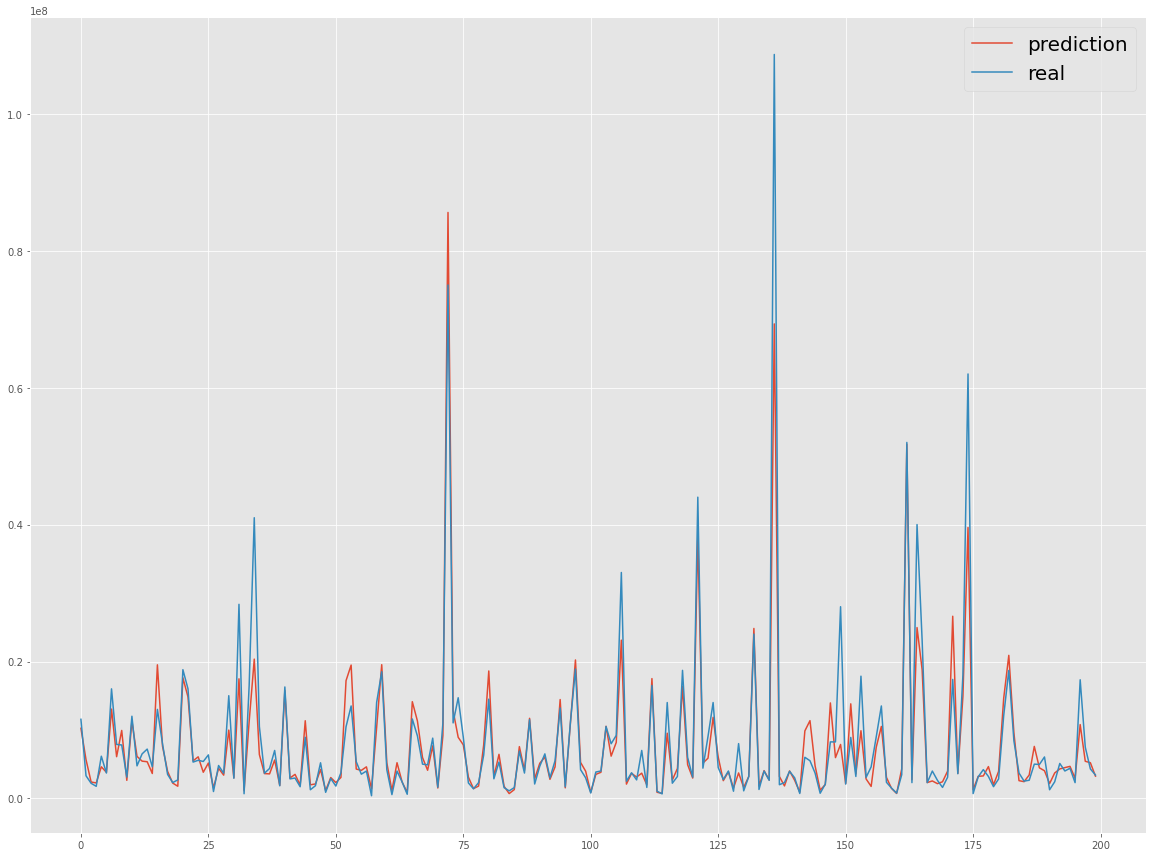

In [156]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [157]:
gb_valid_preds = oof_val_preds
gb_preds = oof_test_preds

## NGBRegressor

In [158]:
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

# 층화 K-Fold 교차 검증기 생성
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # RF training 
    ngb_model = NGBRegressor(random_state = 42, n_estimators = 700)
    ngb_model.fit(X_train, y_train)
    
    # OOF prediction using test data 
    oof_test_preds += ngb_model.predict(X_test) /folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += ngb_model.predict(X_valid)
    
    # NMAE for pred_proba for valid data 
    nmae_score = eval_nmae(y_valid, oof_val_preds[valid_idx], True)
    
    print(f'Fold {idx+1} NMAE Coef. : {nmae_score}\n')

######################################## Fold 1 / Fold 5 ########################################
[iter 0] loss=1.3682 val_loss=0.0000 scale=1.0000 norm=0.9673
[iter 100] loss=0.8233 val_loss=0.0000 scale=2.0000 norm=1.2428
[iter 200] loss=0.3489 val_loss=0.0000 scale=2.0000 norm=1.0155
[iter 300] loss=0.1079 val_loss=0.0000 scale=1.0000 norm=0.4936
[iter 400] loss=0.0058 val_loss=0.0000 scale=1.0000 norm=0.4971
[iter 500] loss=-0.0546 val_loss=0.0000 scale=2.0000 norm=0.9986
[iter 600] loss=-0.0979 val_loss=0.0000 scale=1.0000 norm=0.4975
Fold 1 NMAE Coef. : 0.31131765311623144

######################################## Fold 2 / Fold 5 ########################################
[iter 0] loss=1.3992 val_loss=0.0000 scale=1.0000 norm=0.9871
[iter 100] loss=0.7971 val_loss=0.0000 scale=1.0000 norm=0.6061
[iter 200] loss=0.3068 val_loss=0.0000 scale=2.0000 norm=0.9918
[iter 300] loss=0.0846 val_loss=0.0000 scale=1.0000 norm=0.4823
[iter 400] loss=-0.0158 val_loss=0.0000 scale=1.0000 norm=0.4

In [159]:
ngb_valid_preds = oof_val_preds
ngb_preds = oof_test_preds

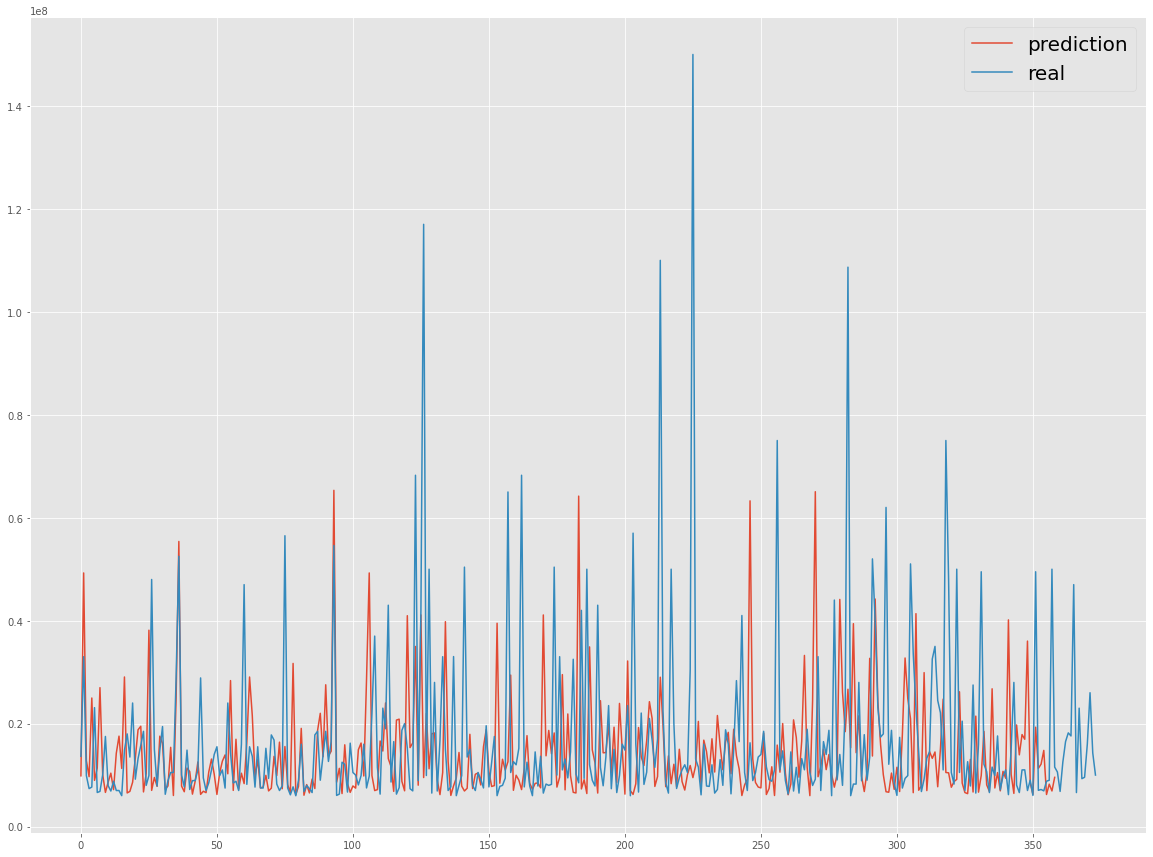

In [160]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp(oof_val_preds[np.exp(oof_val_preds)>6000000]), label = 'prediction')
plt.plot(np.exp(y[np.exp(y)>6000000]), label = 'real')
plt.legend(fontsize = 20)
plt.show()

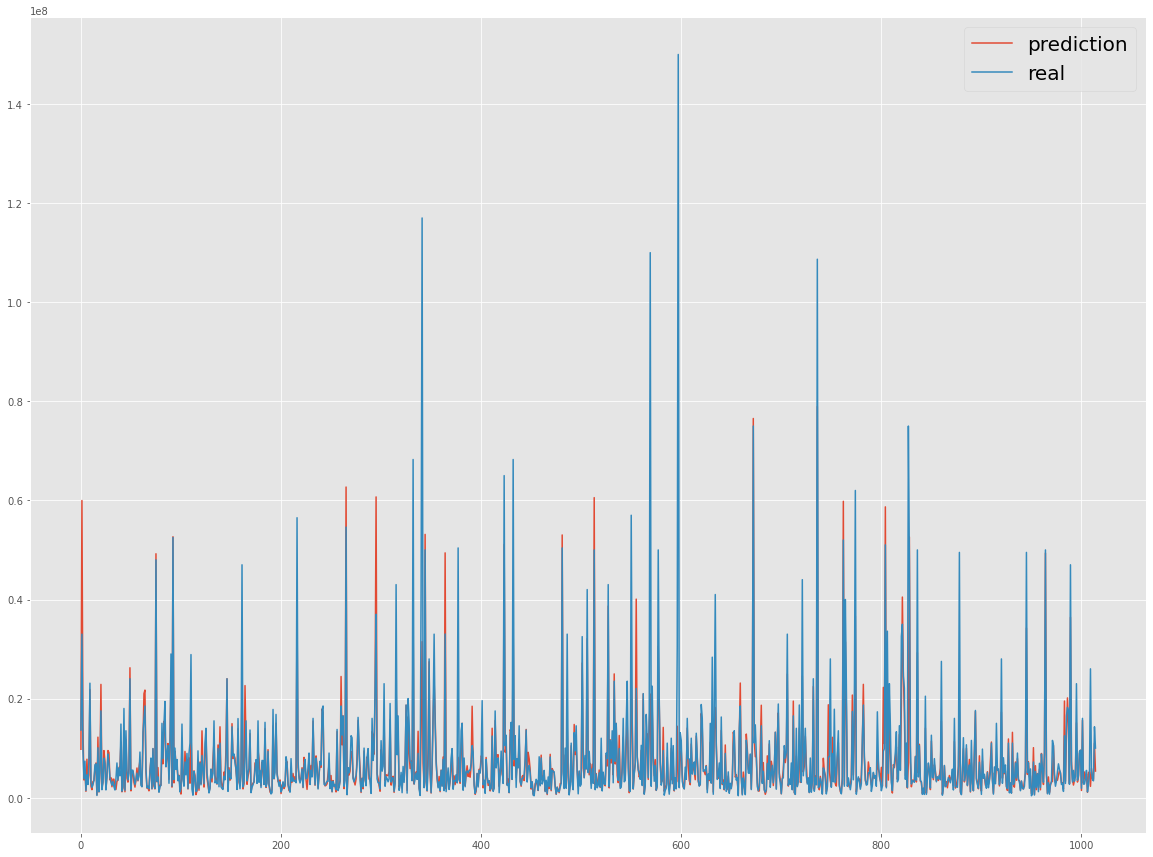

In [161]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens, label = 'prediction')
plt.plot(np.exp(y), label = 'real')
plt.legend(fontsize = 20)
plt.show()

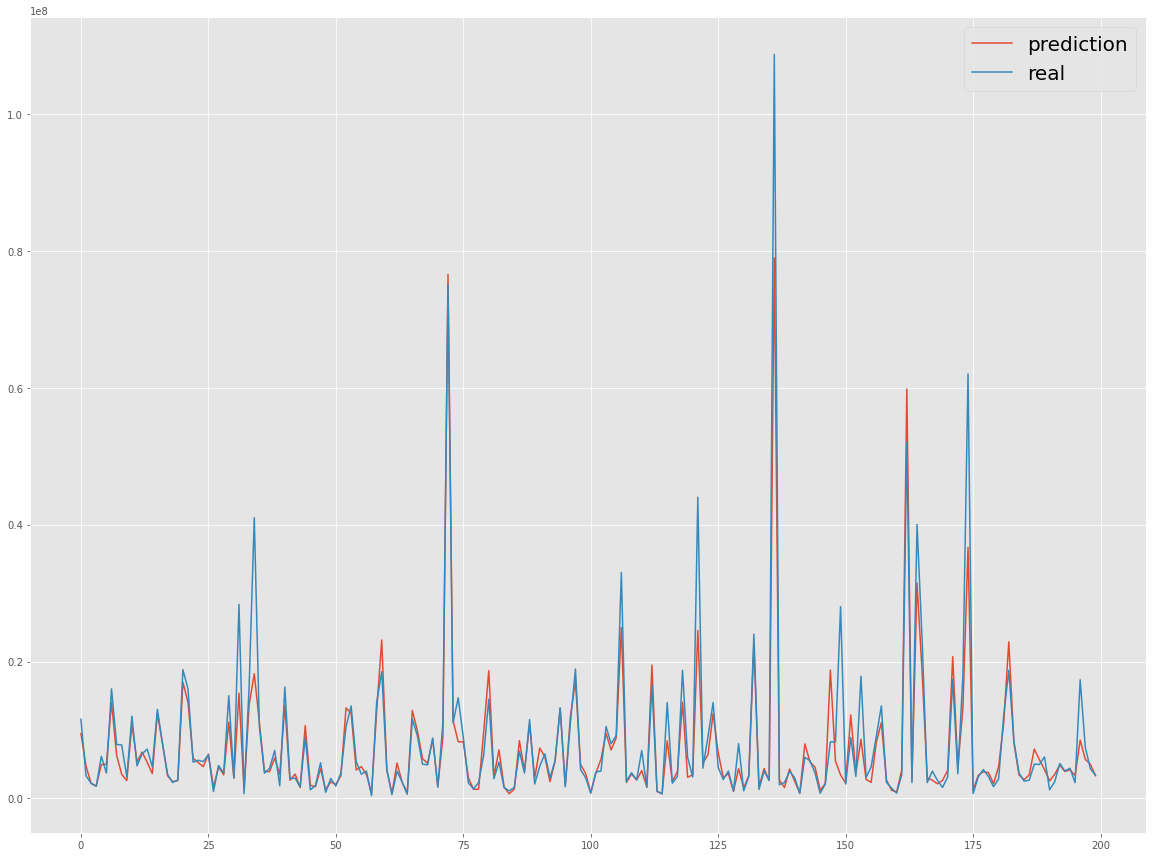

In [162]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

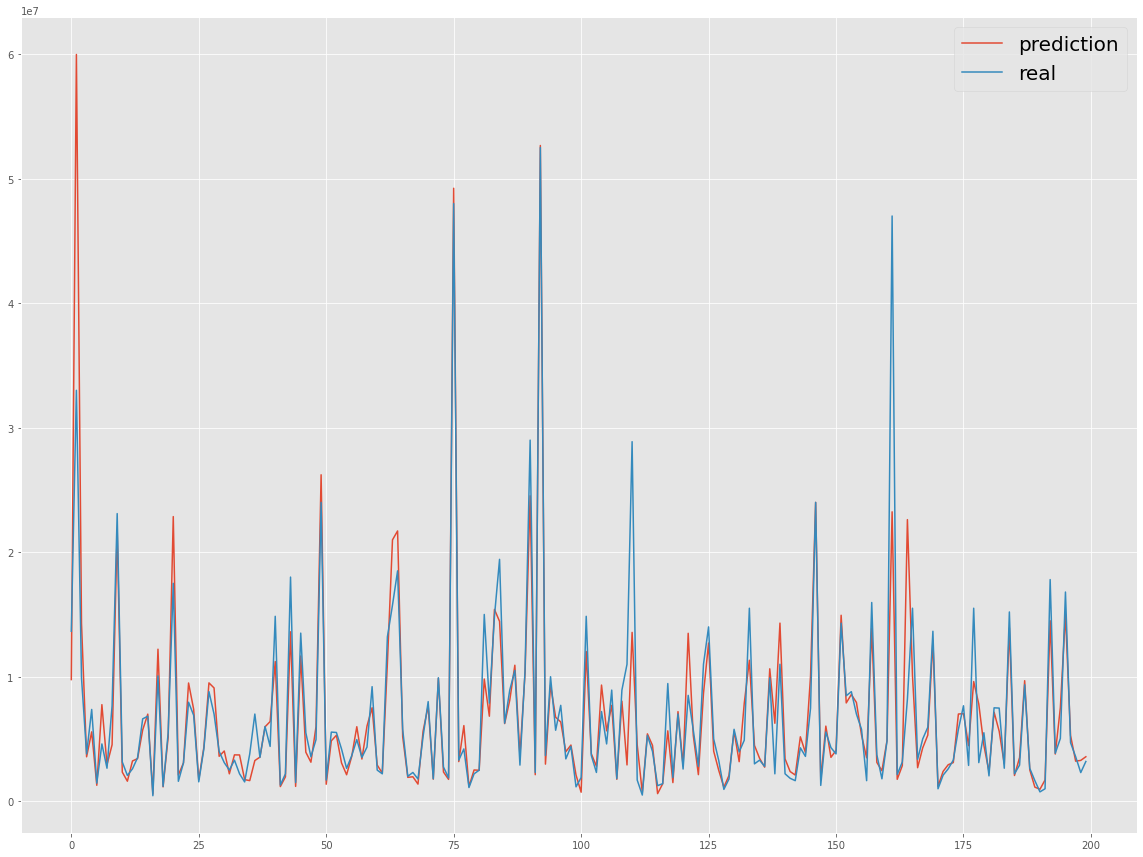

In [163]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(ens[0:200], label = 'prediction')
plt.plot(np.exp(y)[0:200], label = 'real')
plt.legend(fontsize = 20)
plt.show()

## Final

In [164]:
print(eval_nmae(y, rf_valid_preds))
print(eval_nmae(y, ridge_valid_preds))
print(eval_nmae(y, lgb_valid_preds))
print(eval_nmae(y, gb_valid_preds))
print(eval_nmae(y, ngb_valid_preds))

0.2802966408575122
0.3090103670323515
0.3088108058723545
0.2905901399568953
0.2910622677358517


In [197]:
print(eval_nmae(y, (ridge_valid_preds+rf_valid_preds)/2))

0.2672873749733143


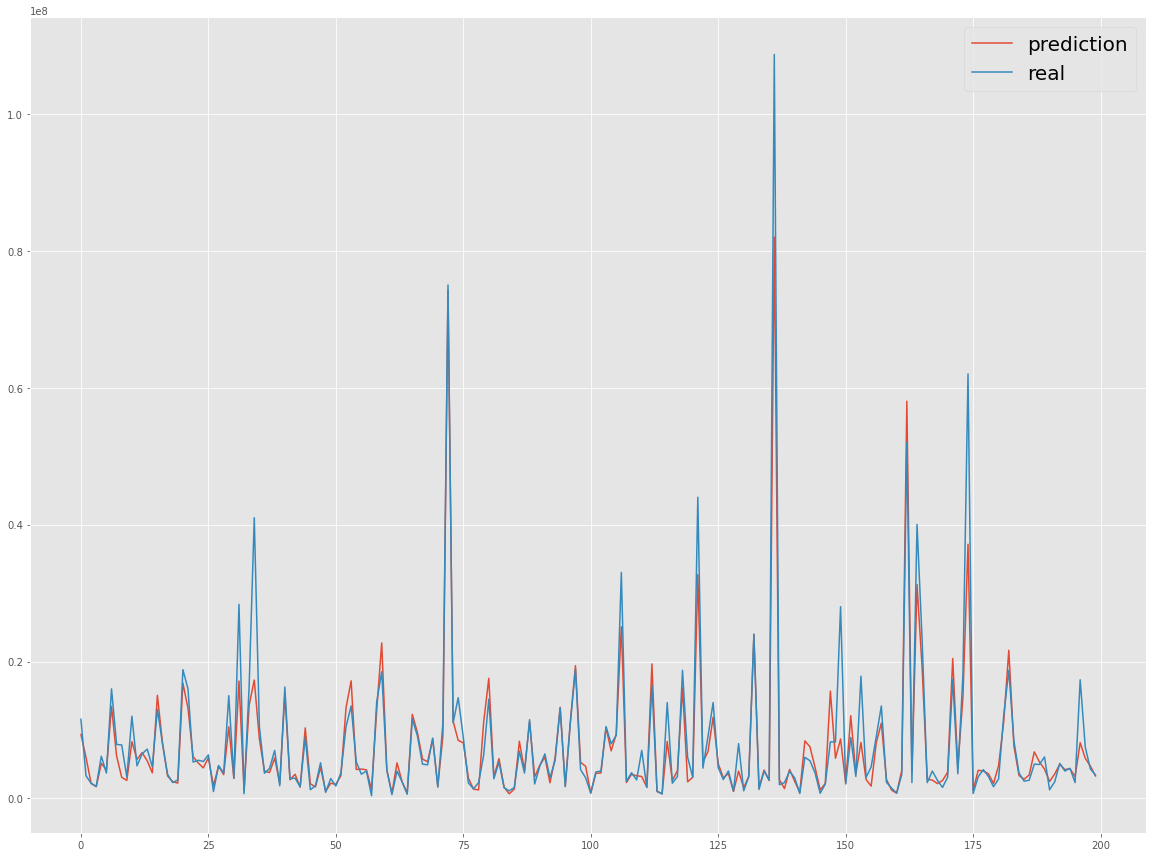

In [202]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 15))
plt.plot(np.exp((ridge_valid_preds+rf_valid_preds)/2)[600:800], label = 'prediction')
plt.plot(np.exp(y)[600:800], label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [205]:
ens_test = np.exp((ridge_preds+rf_preds)/2)

In [206]:
submission['target'] = ens_test
submission.to_csv('submission.csv')

In [207]:
pd.read_csv('submission.csv')

,id,target
0,0,2.044266e+07
1,1,4.360681e+06
2,2,8.583064e+06
3,3,1.232794e+06
4,4,2.232158e+06
...,...,...
431,431,1.082210e+07
432,432,4.867811e+06
433,433,9.840211e+06
434,434,3.432793e+06


# Result

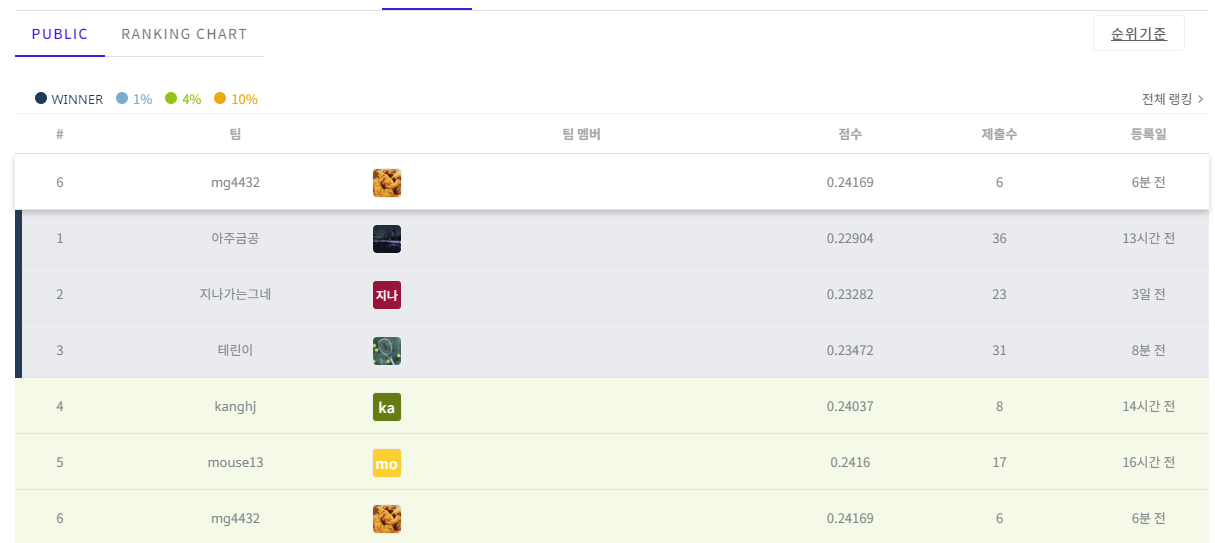